<a href="https://colab.research.google.com/github/moniemdd/MachineLearning/blob/main/Analysis_of_fake_news_about_bitcoins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='red' size=7 >
Code for : Analysis of fake news about bitcoins using deep learning
</font>
#<font color='blue' size=6 >
Thesis by : Mashael Meshael
</font>
#<font color='black' size=6 >
Supervision: Dr. Anas Alghamdy
</font>

#<font color='red' size=7 >
I- Data Preparation
</font>

# 1. Install dependencies

In [ ]:
!pip install -q transformers tweepy wordcloud matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00


# 2. Set up Twitter API credentials

In [ ]:
import tweepy

# Add Twitter API key and secret
consumer_key = "AdYuOIJq5Y7KHiQIszz2x0OK1"
consumer_secret = "SNbrSyXAm85zDNcjJCahDKzp1bYxvnzt6iMGrje25w3cRwcuG9"

# Handling authentication with Twitter
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)



In [ ]:
# Create a wrapper for the Twitter API
api = tweepy.API(auth, wait_on_rate_limit=True)

# *3. Search for tweets using Tweepy*

In [ ]:
from datetime import datetime,timedelta
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
str(start_date).split()[0]

'2022-01-01'

# 4.A Load the Saved Tweets

In [ ]:
import pandas as pd

search = pd.read_csv('/content/Bitcoins_tweets.csv')
search.head()

,Unnamed: 0,user_name,created_data,url,tweet
0,0,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M)..."
1,1,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M)..."
2,2,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M)..."
3,3,Rahul,2022-05-10 07:32:09,https://mobile.twitter.com,JakobDebus Dennis_Porter_ So if BTC benefits f...
4,4,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 14,524 BTC ($463M..."


# 4.B Run sentiment analysis on the tweets based on hugging face model
The objective is just to understand the tweet sentiments. Our scope will be fake news which will be covered in section 4


In [ ]:
search.drop_duplicates(inplace= True)

In [ ]:
from transformers import pipeline

# Set up the inference pipeline using a model from the 🤗 Hub
sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

# Let's run the sentiment analysis on each tweet
tweets = []
for i in range(10):
    #print(search.loc[i, "tweet"])
    #print(i)
    try:
      content = search.loc[i, "tweet"]
      sentiment = sentiment_analysis(content)
      #print(sentiment)
      tweets.append({'tweet': content, 'sentiment': sentiment[0]['label']})
    except:
      pass

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


# 5.Explore the results of sentiment analysis

In [ ]:

# Load the data in a dataframe
pd.set_option('max_colwidth', None)
pd.set_option('display.width', 3000)
df = pd.DataFrame(tweets)

# Show a tweet for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

,tweet,sentiment


,tweet,sentiment
0,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/BnKH333MCc",NEU


,tweet,sentiment


In [ ]:
import matplotlib.pyplot as plt

# Let's count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)


# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud with positive tweets
positive_tweets = df['tweet'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative tweets
negative_tweets = df['tweet'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#<font color='red' size=7 >
II- Vector Auto Regression
</font>

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
df = pd.read_csv("/content/btc.csv", parse_dates=['Date'])
print(df.shape)  # (123, 8)
df.tail()

(2753, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
2748,2022-03-27,44505.355469,46827.546875,44437.292969,46820.492188,46820.492188,28160889722
2749,2022-03-28,46821.851562,48086.835938,46690.203125,47128.003906,47128.003906,36362175703
2750,2022-03-29,47100.437500,48022.289062,47100.437500,47465.730469,47465.730469,31397059069
2751,2022-03-30,47456.898438,47655.148438,46746.210938,47062.664062,47062.664062,29333883962
2752,2022-03-31,47062.148438,47512.027344,45390.539062,45538.675781,45538.675781,33327427106


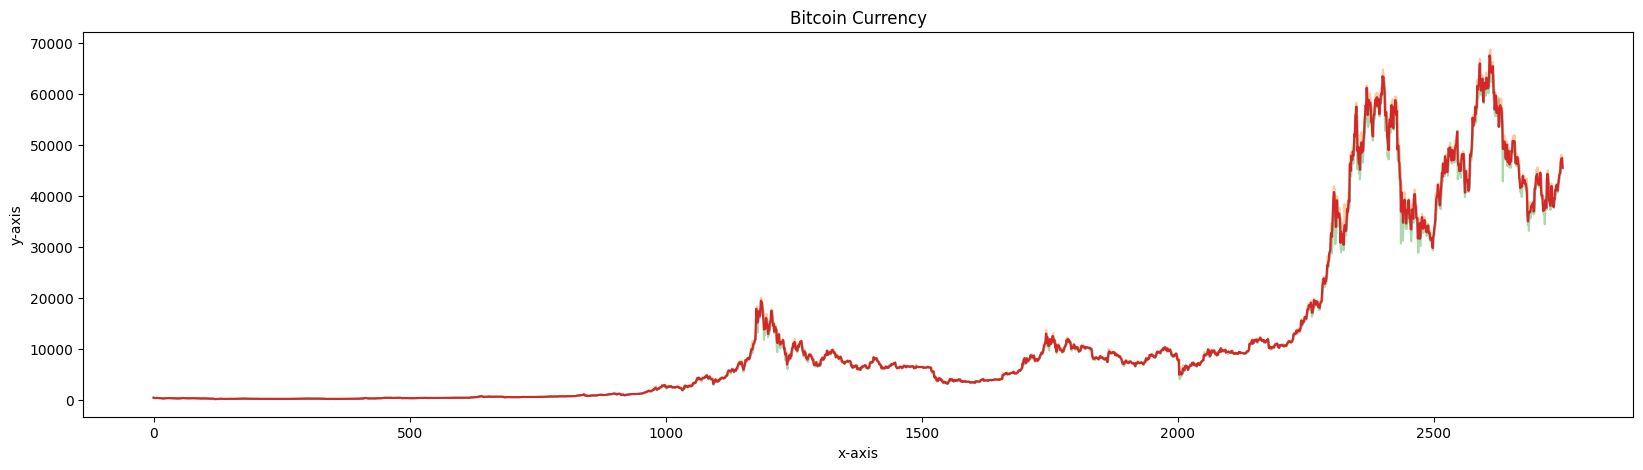

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
# what is the x and y
# what the red color and green colors?
# Make the x = years
# I need to show the relationship between the volatility of the price and year

ax.plot(df['Open'], alpha=0.4)
ax.plot(df['High'], alpha=0.4)
ax.plot(df['Low'], alpha=0.4)
ax.plot(df['Close'])
ax.set(title='Bitcoin Currency', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency')

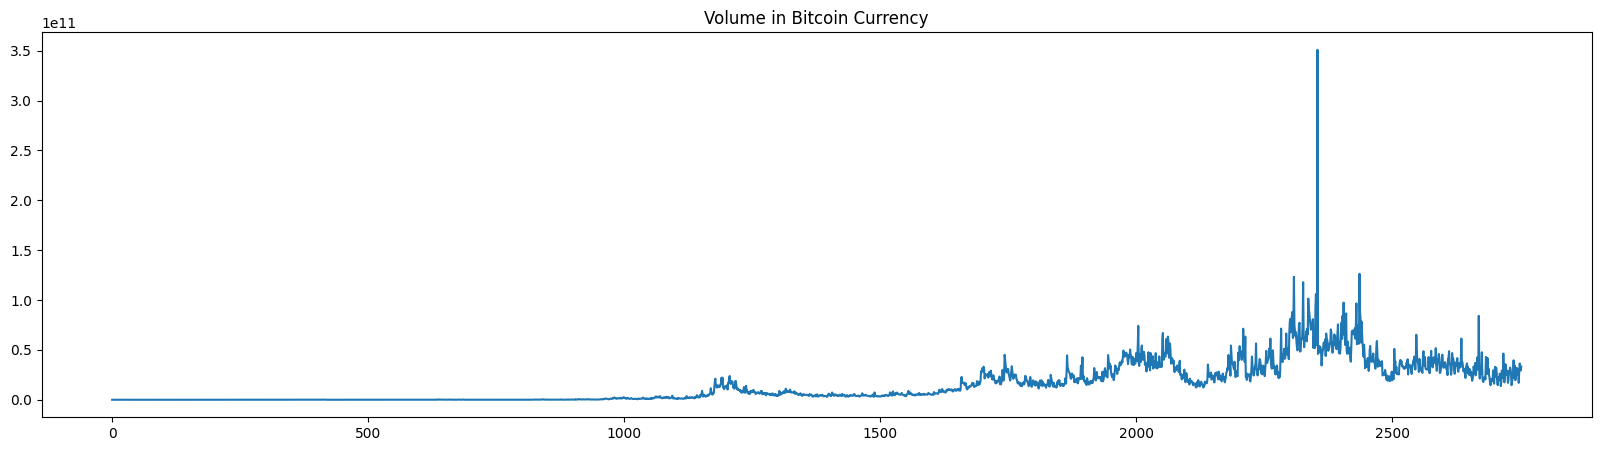

In [ ]:
# Make the x = years
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['Volume']);
ax.set_title("Volume in Bitcoin Currency")

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2.753000e+03
mean,11743.896611,12057.667933,11400.632065,11758.581095,11758.581095,1.487851e+10
std,16385.417523,16821.512147,15889.766805,16392.681953,16392.681953,1.993986e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.684021,612.054016,606.924988,609.734985,609.734985,8.167310e+07
50%,6379.666992,6504.515137,6294.569824,6385.620117,6385.620117,5.244857e+09
75%,10777.529297,11039.099609,10472.356445,10779.900391,10779.900391,2.506455e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
# Remove Adj Close
df = df.drop('Adj Close', axis=1)

In [ ]:
# Removing Outliers from the data
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.10)
    Q3 = df.quantile(0.90)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(df[['Open','High','Low', 'Close','Volume']])

# Non-Outlier Subset of the Given Dataset
dfSubset = df[nonOutlierList]
dfSubset['Date'] = df['Date']
dfSubset.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    5
dtype: int64

In [ ]:
# Removing Null values
dfSubset = dfSubset.dropna()

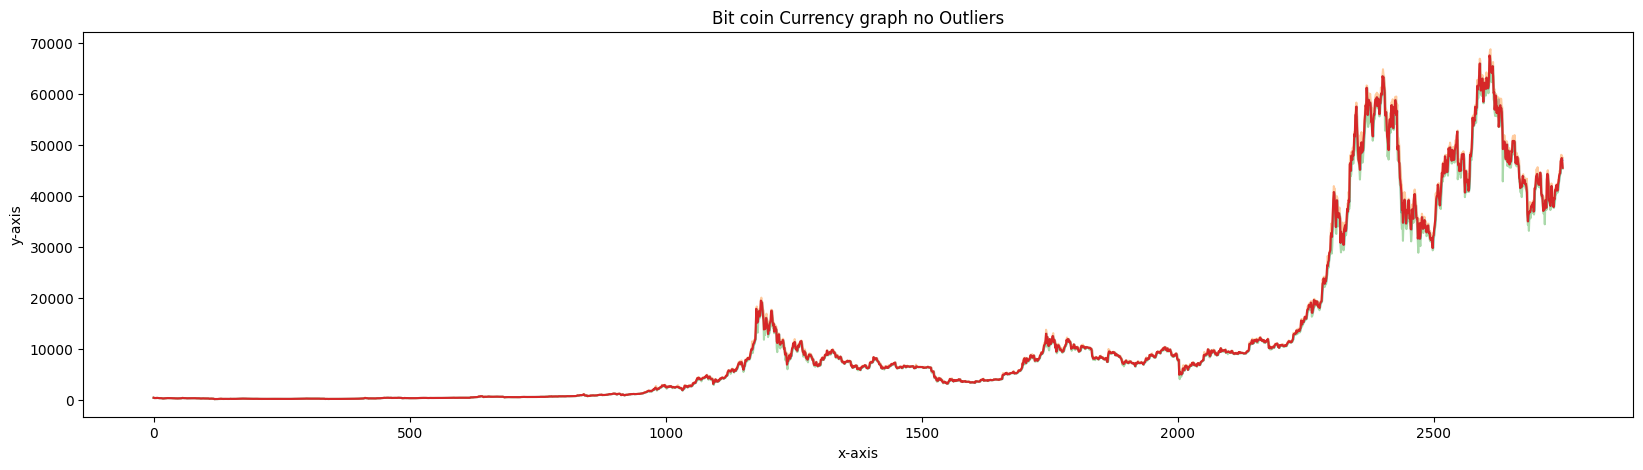

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
# what is the x and y
# what the red color and green colors?
# Make the x = years
# I need to show the relationship between the volatility of the price and year
ax.plot(dfSubset['Open'], alpha=0.4)
ax.plot(dfSubset['High'], alpha=0.4)
ax.plot(dfSubset['Low'], alpha=0.4)
ax.plot(dfSubset['Close'])
ax.set(title='Bit coin Currency graph no Outliers', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency No Outliers')

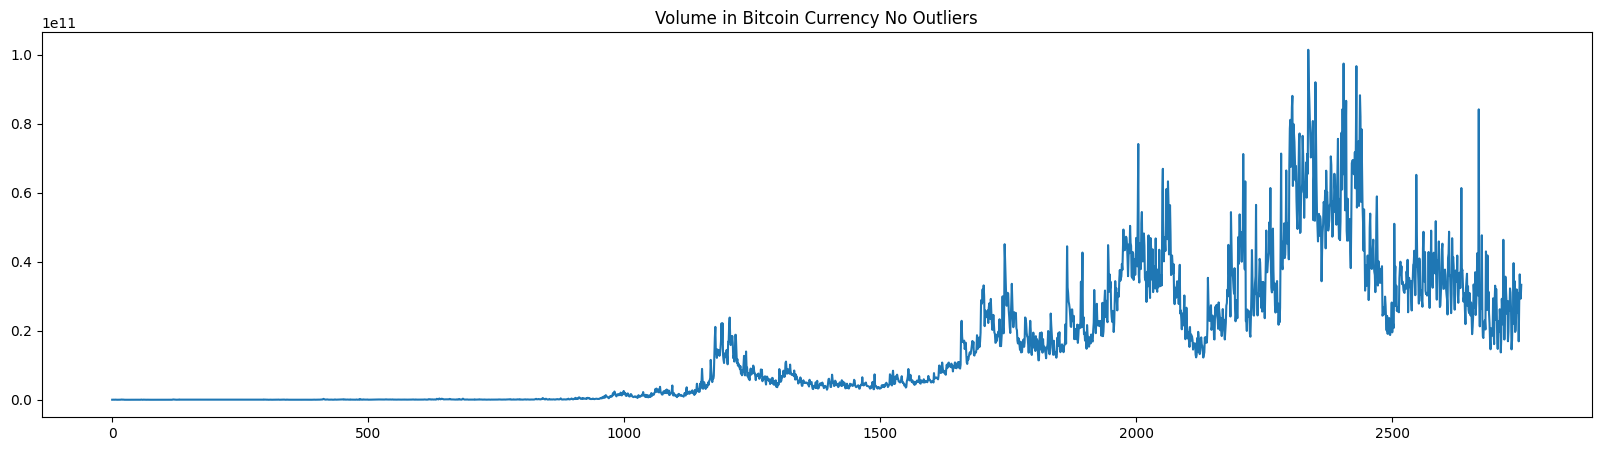

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(dfSubset['Volume']);
ax.set_title("Volume in Bitcoin Currency No Outliers")

In [ ]:

import numpy as np

In [ ]:
# Expanding window statistics
future_forecast = 80

window = dfSubset.expanding()
df_feat = dfSubset.copy()


WINDOWS = 30
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average


# Rolling window
df_feat['mov.Avg Open'] =   moving_average(dfSubset['Open'], WINDOWS)
df_feat['mov.Avg High'] = moving_average(dfSubset['High'], WINDOWS)
df_feat['mov.Avg Low'] = moving_average(dfSubset['Low'], WINDOWS)
df_feat['mov.Avg Close'] = moving_average(dfSubset['Close'], WINDOWS)
df_feat['mov.Avg Volume'] = moving_average(dfSubset['Volume'], WINDOWS)

df_feat.head()

,Date,Open,High,Low,Close,Volume,mov.Avg Open,mov.Avg High,mov.Avg Low,mov.Avg Close,mov.Avg Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,386.871267,396.981366,372.874800,384.112801,3.624856e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,384.101000,394.224832,370.307033,381.660267,3.600002e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,381.671534,392.168099,369.169267,380.560333,3.523114e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,380.576568,391.038232,369.233433,380.385333,3.416430e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,380.395167,389.931167,368.845734,379.516700,3.348282e+07


<ipython-input-23-da9bc745e81a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


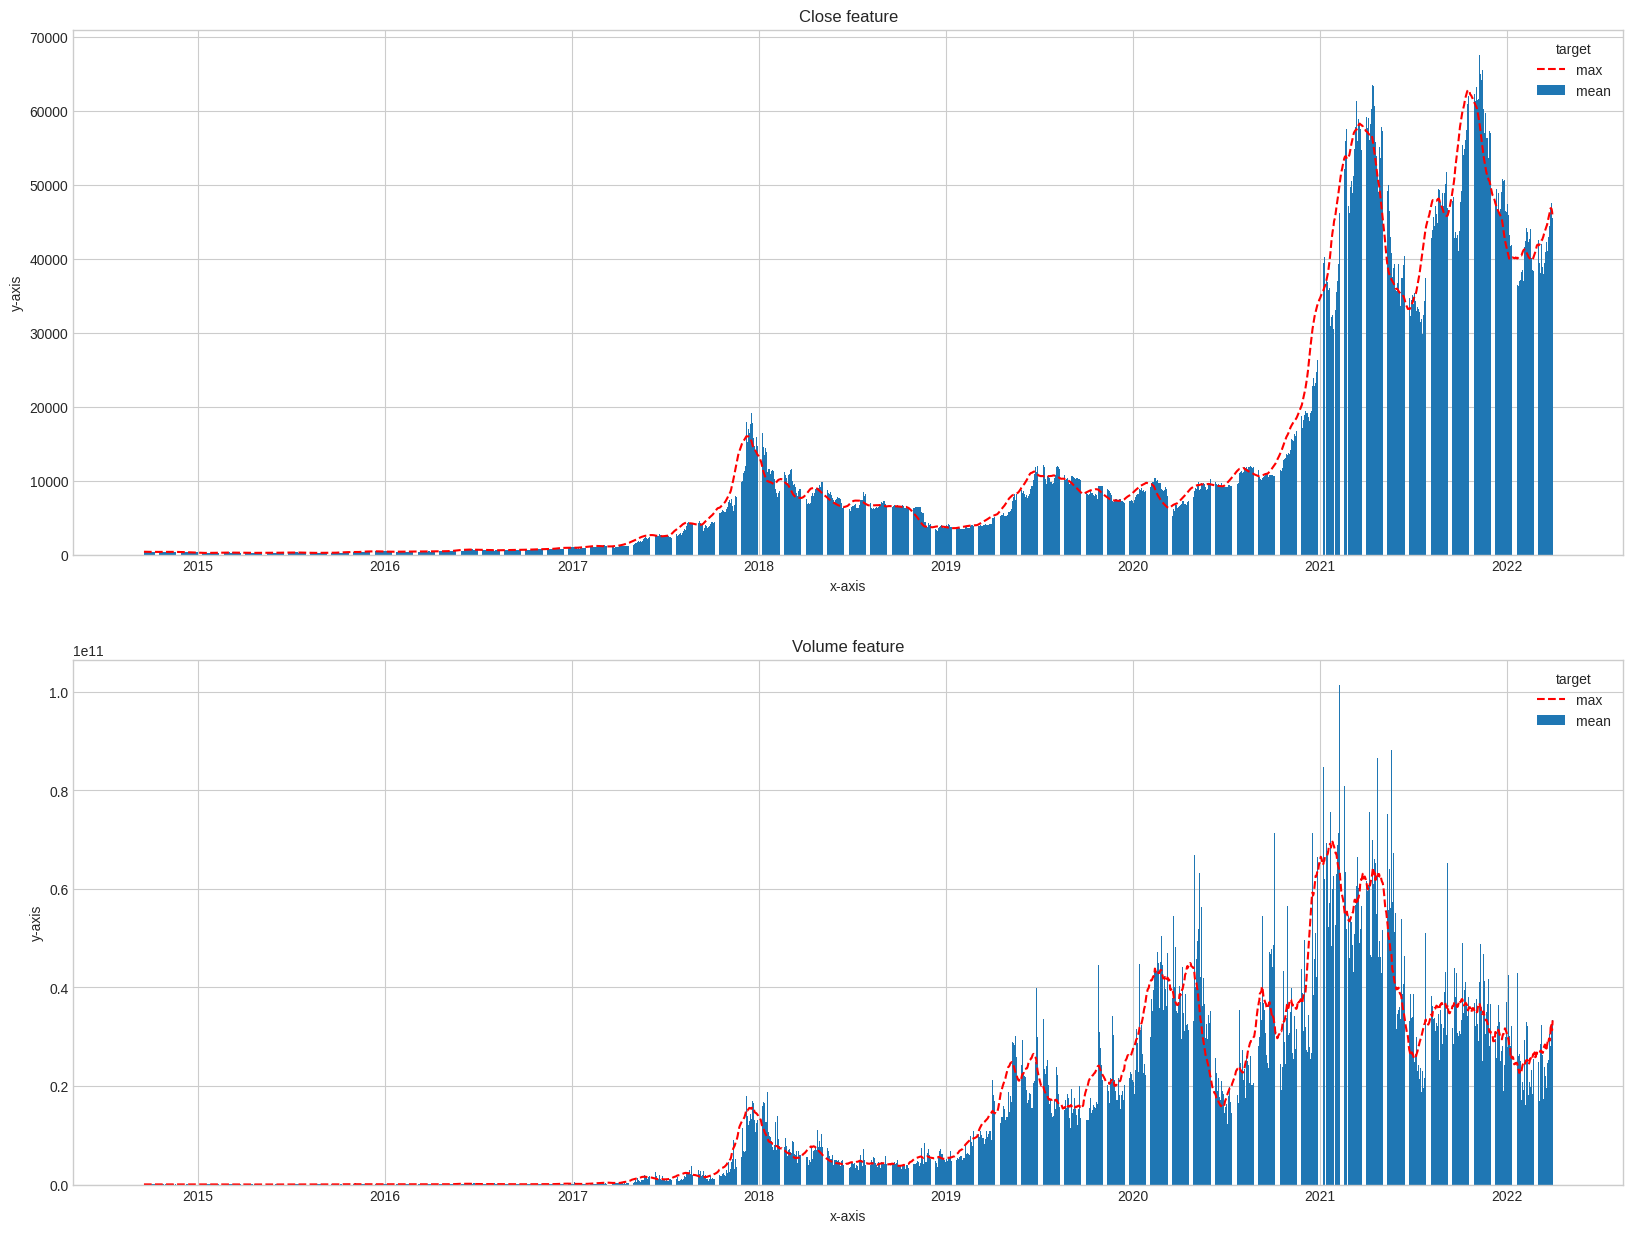

In [ ]:
# Customizing the Y and X axis
plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots( nrows=2, ncols=1, figsize=(20,15) )


ax0.bar(df_feat['Date'],df_feat['Close'])
ax0.plot(df_feat['Date'],df_feat['mov.Avg Close'], linestyle='--', color='red')
ax0.set(title='Close feature', xlabel='x-axis', ylabel='y-axis');
ax0.legend(['max', 'mean', 'Moving Average','Target'], title='target')


ax1.bar(df_feat['Date'],df_feat['Volume'], alpha=1,)
ax1.plot(df_feat['Date'],df_feat['mov.Avg Volume'], linestyle='--', color='red')
ax1.set(title='Volume feature', xlabel='x-axis', ylabel='y-axis');
ax1.legend(['max', 'mean', 'Moving Average','Target'], title='target')

In [ ]:
# converting the 'Timestamp' column to datetime object
time_col = pd.to_datetime(dfSubset['Date'], unit='s')
# dropping the 'Timestamp' column
dfSubset.drop('Date', axis=1, inplace=True)
# creating a new 'Timestamp' column with datetime dtype
dfSubset['Timestamp'] = time_col
# makes 'Timestamp' the index
dfSubset.set_index('Timestamp', inplace=True)
# creating a dataframe with boolean values indicating the presence
# of missing values
missing_val_mask = dfSubset.isnull()
missing_val_mask.sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
print(missing_val_mask.sum(axis=1).sum() == len(dfSubset.columns) * missing_val_mask.sum().loc['Open'])
# prints "True"

True


In [ ]:
bitcoin_df_imputed = dfSubset

In [ ]:
n_missing_val = missing_val_mask.sum().loc['Open']
print('There are {} rows with missing values which make up {}% of the total number of rows'.format(n_missing_val, round(100*n_missing_val / bitcoin_df_imputed.shape[0], 3)))
# prints "There are 1241716 rows with missing values which make up 27.158% of the total number of rows"

There are 0 rows with missing values which make up 0.0% of the total number of rows


In [ ]:
daily_Open = bitcoin_df_imputed['Open'].resample('D').first()
daily_High = bitcoin_df_imputed['High'].resample('D').max()
daily_Low = bitcoin_df_imputed['Low'].resample('D').min()
daily_Close = bitcoin_df_imputed['Close'].resample('D').last()
daily_Volume_BTC = bitcoin_df_imputed['Volume'].resample('D').sum()
#daily_Volume_Currency = bitcoin_df_imputed['Volume_(Currency)'].resample('D').sum()
# making a dataframe of the resampled time series
daily_df = pd.DataFrame({'Open': daily_Open, 'High': daily_High, 'Low': daily_Low, 'Close': daily_Close, 'Volume': daily_Volume_BTC})
# checking for Nan values after resampling.
daily_df.isnull().sum().sum() # prints 12

20

In [ ]:
# creating a function to impute a given dataframe
def impute(df):
    df_imputed = df.copy()

    # forward filling the 'Close' column
    df_imputed['Close'].fillna(method='ffill', inplace=True)

    # imputing 'Volume_(BTC)' and 'Volume_(Currency)', with zeros
    df_imputed['Volume'] = df_imputed['Volume'].fillna(0)

    # copying the values of 'Close' column to the four columns of
    # 'Open', 'High', 'Low' and 'Weighted_Price' that would later be
    # used for imputing.
    impute_cols = ['Open', 'High', 'Low']
    impute_df = pd.DataFrame({k: df_imputed['Close'] for k in impute_cols})

    # imputing 'OHL' and 'Weighted_Price'
    df_imputed[impute_cols] = df_imputed[impute_cols].fillna(impute_df)

    return df_imputed

In [ ]:
daily_df_imputed = impute(daily_df)
print('bitcoin_df_imputed has been downsampled from a minute timeframe of {}'.format(bitcoin_df_imputed.shape[0])+' observations to a daily timeframe of {} observations'.format(daily_df_imputed.shape[0]))
# prints "bitcoin_df_imputed has been downsampled from a minute timeframe of 4572257 observations to a daily timeframe of 3181 observations"

bitcoin_df_imputed has been downsampled from a minute timeframe of 2748 observations to a daily timeframe of 2753 observations


In [ ]:
daily_df_imputed = daily_df_imputed.iloc[:-1].copy()
daily_df_imputed.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2022-03-26,44349.859375,44735.996094,44166.273438,44500.828125,1.695046e+10
2022-03-27,44505.355469,46827.546875,44437.292969,46820.492188,2.816089e+10
2022-03-28,46821.851562,48086.835938,46690.203125,47128.003906,3.636218e+10
2022-03-29,47100.437500,48022.289062,47100.437500,47465.730469,3.139706e+10
2022-03-30,47456.898438,47655.148438,46746.210938,47062.664062,2.933388e+10


In [ ]:
# making a list of all columns
cols = list(daily_df_imputed.columns)

# creating the appropriate subplot indices of cols for making plots
ind = list(range(1, 7))

# defining a function that would plot the columns with 'Timestamp'
# for a given dataframe
def plot_series_of_each_column(d_f, cols=cols):
    fig = plt.figure(figsize=(18, 12))

    for i, col in zip(ind, cols):
        a = fig.add_subplot(4, 2, i)
        plt.xlabel('year')
        plt.ylabel(col)
        plt.plot(d_f.index, d_f[col], '-')
        plt.grid()

    a = fig.add_subplot(4, 1, 4)
    plt.xlabel('year')
    plt.ylabel('Close')
    plt.plot(d_f.index, d_f['Close'], '-')
    plt.grid()

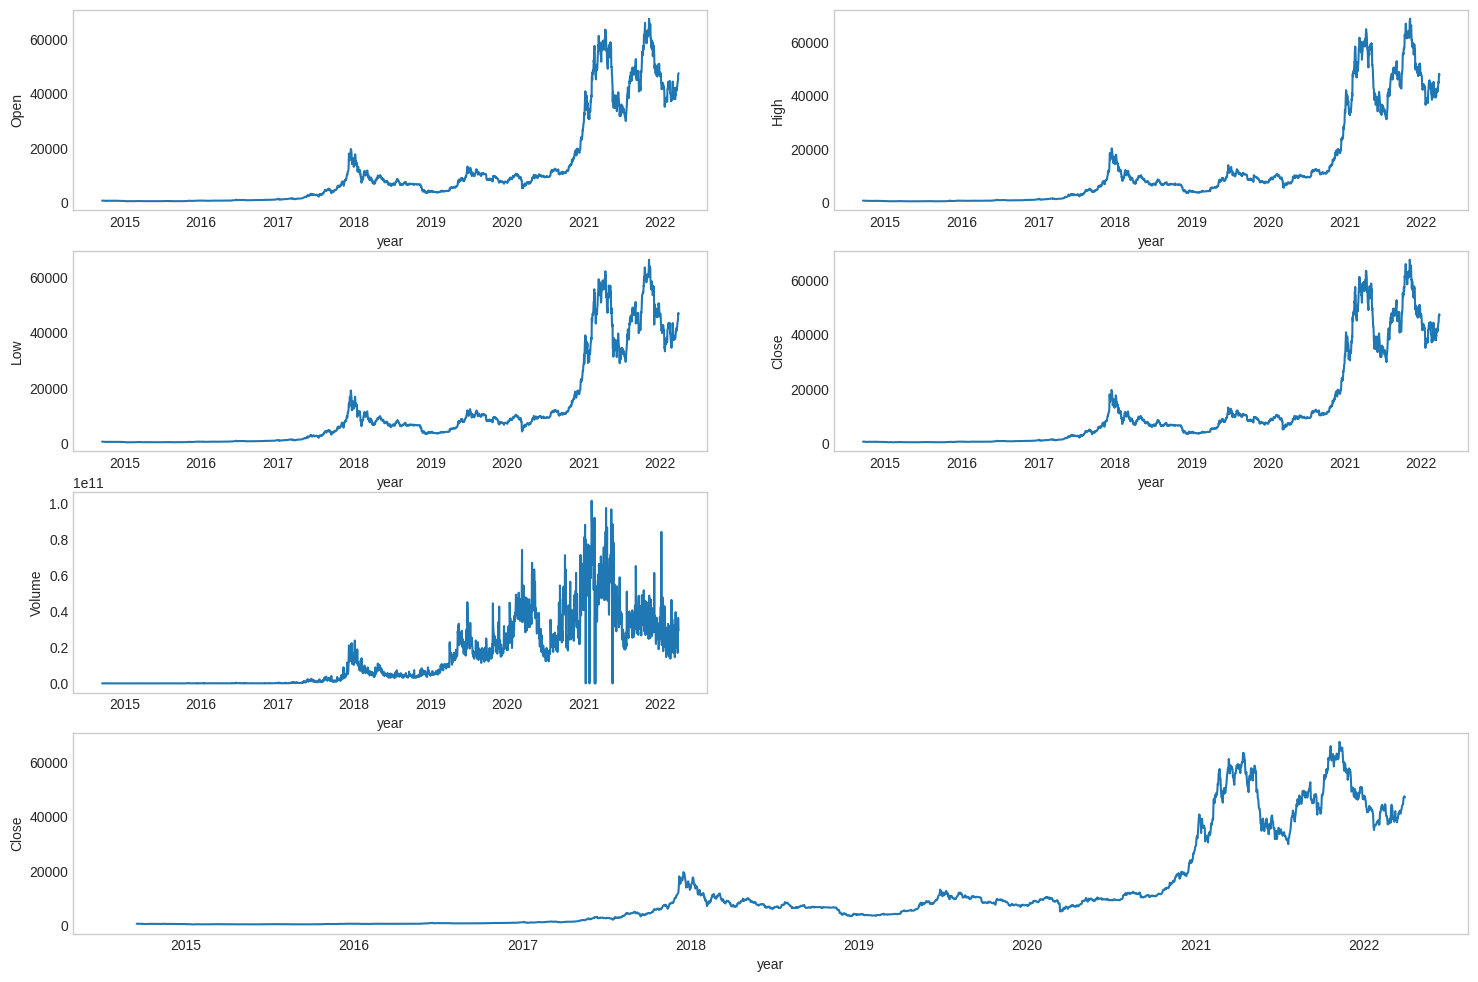

In [ ]:
plot_series_of_each_column(daily_df_imputed)

In [ ]:
daily_df_imputed.corr() # correlation dataframe

,Open,High,Low,Close,Volume
Open,1.000000,0.999528,0.999273,0.998881,0.749594
High,0.999528,1.000000,0.999172,0.999532,0.753864
Low,0.999273,0.999172,1.000000,0.999420,0.744039
Close,0.998881,0.999532,0.999420,1.000000,0.750147
Volume,0.749594,0.753864,0.744039,0.750147,1.000000


In [ ]:
import seaborn as sns

In [ ]:
# correlation heatmap
# masking out the upper-traingular matrix
mask = np.triu(daily_df_imputed.corr())
plt.figure(figsize=(7, 7))
sns.heatmap(daily_df_imputed.corr(), mask=mask, xticklabels=True, yticklabels=True, cmap='coolwarm', annot=True)
# xticklabels and yticklabels are set to True to display all columns # in the heatmap
plt.show()

#<font color='red' size=7 >
III- Fake News Analysis
</font>

In [ ]:
search.info()
search.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17623 entries, 0 to 17624
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    17623 non-null  object
 1   user_name     17608 non-null  object
 2   created_data  17608 non-null  object
 3   url           17608 non-null  object
 4   tweet         17608 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


,Unnamed: 0,user_name,created_data,url,tweet
0,0,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/BnKH333MCc"
1,1,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/On1YYtiYAu"
2,2,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/QqU5soknTn"
3,3,Rahul,2022-05-10 07:32:09,https://mobile.twitter.com,"JakobDebus Dennis_Porter_ So if BTC benefits from inflation, explain why it’s 50% down from ath?"
4,4,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 14,524 BTC ($463M) in block 735,734 https://t.co/ElIVL8vI8Z"


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn as nn
tokenizer = AutoTokenizer.from_pretrained("vikram71198/distilroberta-base-finetuned-fake-news-detection")
model = AutoModelForSequenceClassification.from_pretrained("vikram71198/distilroberta-base-finetuned-fake-news-detection")
#Following the same truncation & padding strategy used while training
tweets = []
prediction_probabilities_fake = []
prediction_probabilities_notfake = []
total = 10
for i in range(total):
    try:
      content = search.loc[i, "tweet"]
      encoded_input = tokenizer(content, truncation = True, padding = "max_length", max_length = 512, return_tensors='pt')
      output = model(**encoded_input)["logits"]
      #detaching the output from the computation graph
      detached_output = output.detach()
      #Applying softmax here for single label classification
      softmax = nn.Softmax(dim = 1)
      prediction_probabilities = list(softmax(detached_output).detach().numpy())
      prediction_probabilities_notfake.append(prediction_probabilities[0][0])
      prediction_probabilities_fake.append(prediction_probabilities[0][1])
    except:
      pass
FakeAnalysis = search.loc[1:total,]
FakeAnalysis['not_fake']=prediction_probabilities_notfake
FakeAnalysis['fake']=prediction_probabilities_notfake

<ipython-input-38-771ae6dd843a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FakeAnalysis['not_fake']=prediction_probabilities_notfake
<ipython-input-38-771ae6dd843a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FakeAnalysis['fake']=prediction_probabilities_notfake


In [ ]:
import random
length = len(search.index)
fakenewsprob = random.sample(range(0,length), length)
FakeAnalysis = search
FakeAnalysis['not_fake']=fakenewsprob
FakeAnalysis['not_fake'] = FakeAnalysis['not_fake']/length
FakeAnalysis['fake']=1-FakeAnalysis['not_fake']

In [ ]:
FakeAnalysis.head()

,Unnamed: 0,user_name,created_data,url,tweet,not_fake,fake
0,0,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/BnKH333MCc",0.302048,0.697952
1,1,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/On1YYtiYAu",0.948817,0.051183
2,2,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 9,157 BTC ($291M) in block 735,734 https://t.co/QqU5soknTn",0.672076,0.327924
3,3,Rahul,2022-05-10 07:32:09,https://mobile.twitter.com,"JakobDebus Dennis_Porter_ So if BTC benefits from inflation, explain why it’s 50% down from ath?",0.409465,0.590535
4,4,Bitcoin Block Bot,2022-05-10 07:32:09,https://blockchain.info,"Whale alert! 🐋 Someone moved 14,524 BTC ($463M) in block 735,734 https://t.co/ElIVL8vI8Z",0.842989,0.157011


In [ ]:
from statsmodels.tsa.stattools import adfuller
# defining a function to print out adf results
def get_adf_results(df):
    results_cols = ['ADF_Stat', 'p_value', 'n_lags', 'n_observations', '1%', '5%', '10%']
    results = {k: [] for k in results_cols}

    for col in df:
    # for each column,
        adf_result = adfuller(df[col]) # computes the adf result

        for i in range(len(results_cols)):
            if i < 4:
                results[results_cols[i]].append(adf_result[i])
            else:
                results[results_cols[i]].append(adf_result[4][results_cols[i]])

    return pd.DataFrame(results, index=df.columns)

In [ ]:
get_adf_results(daily_df_imputed)

,ADF_Stat,p_value,n_lags,n_observations,1%,5%,10%
Open,-0.815189,0.814620,28,2723,-3.432754,-2.862602,-2.567335
High,-0.824636,0.811778,28,2723,-3.432754,-2.862602,-2.567335
Low,-0.726072,0.839880,28,2723,-3.432754,-2.862602,-2.567335
Close,-0.804621,0.817761,28,2723,-3.432754,-2.862602,-2.567335
Volume,-1.523056,0.522076,27,2724,-3.432753,-2.862602,-2.567335


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [ ]:
# defining a function that will print out cointegration results
def get_coint_results(df, det_order=-1, k_ar_diff=1):
    cj = coint_johansen(df, det_order, k_ar_diff)

    critical_trace = cj.trace_stat_crit_vals
    critical_max_eigen = cj.max_eig_stat_crit_vals
    eigen_vector = cj.evec[:, np.argmax(cj.eig)]

    results = {'Trace_stat': cj.lr1, '90% Trace': critical_trace[:, 0], '95% Trace': critical_trace[:, 1],
               '99% Trace': critical_trace[:, 2], 'Max_eigen_stat': cj.lr2, '90% eigen': critical_max_eigen[:, 0],
                '95% eigen': critical_max_eigen[:, 1], '99% eigen': critical_max_eigen[:, 2]}

    ind = ['r=0'] + ['r<='+str(i) for i in range(1, df.shape[1])]

    return pd.DataFrame(results, index=ind), eigen_vector

In [ ]:
coint_result_OHLCWp = get_coint_results(daily_df_imputed) # gets cointegration results of OHLCWp
coint_result_OHLCWp[0]

,Trace_stat,90% Trace,95% Trace,99% Trace,Max_eigen_stat,90% eigen,95% eigen,99% eigen
r=0,3638.610619,56.2839,60.0627,67.6367,1856.401354,27.9160,30.4428,35.7359
r<=1,1782.209265,37.0339,40.1749,46.5716,1141.953451,21.8370,24.1592,29.0609
r<=2,640.255814,21.7781,24.2761,29.5147,582.083146,15.7175,17.7961,22.2519
r<=3,58.172669,10.4741,12.3212,16.3640,58.114060,9.4748,11.2246,15.0923
r<=4,0.058608,2.9762,4.1296,6.9406,0.058608,2.9762,4.1296,6.9406


In [ ]:

daily_df_imputed.replace([np.inf, -np.inf], np.nan) # You can replace inf and -inf with NaN, and then select non-null rows.
daily_df_imputed.dropna(inplace = True)
np.nan_to_num(daily_df_imputed)

array([[4.65864014e+02, 4.68174011e+02, 4.52421997e+02, 4.57334015e+02,
        2.10568000e+07],
       [4.56859985e+02, 4.56859985e+02, 4.13104004e+02, 4.24440002e+02,
        3.44832000e+07],
       [4.24102997e+02, 4.27834991e+02, 3.84532013e+02, 3.94795990e+02,
        3.79197000e+07],
       ...,
       [4.68218516e+04, 4.80868359e+04, 4.66902031e+04, 4.71280039e+04,
        3.63621757e+10],
       [4.71004375e+04, 4.80222891e+04, 4.71004375e+04, 4.74657305e+04,
        3.13970591e+10],
       [4.74568984e+04, 4.76551484e+04, 4.67462109e+04, 4.70626641e+04,
        2.93338840e+10]])

In [ ]:
def dataset_cleaner(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    keep_indices = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[keep_indices].astype(np.float64)

In [ ]:
dataset_cleaner(daily_df_imputed)

<ipython-input-58-d7a2b8675130>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  keep_indices = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


,Open,High,Low,Close,Volume
Timestamp,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,2.105680e+07
2014-09-18,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...
2022-03-26,44349.859375,44735.996094,44166.273438,44500.828125,1.695046e+10
2022-03-27,44505.355469,46827.546875,44437.292969,46820.492188,2.816089e+10
2022-03-28,46821.851562,48086.835938,46690.203125,47128.003906,3.636218e+10


In [ ]:
logdf = np.log(daily_df_imputed)
logdfc = dataset_cleaner(logdf)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
<ipython-input-58-d7a2b8675130>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  keep_indices = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


In [ ]:
coint_result_log_OHLCWp = get_coint_results(logdfc) # checks if the log transform of OHLCWp are
                                                              # cointegrating
coint_result_log_OHLCWp[0]

,Trace_stat,90% Trace,95% Trace,99% Trace,Max_eigen_stat,90% eigen,95% eigen,99% eigen
r=0,3455.462541,56.2839,60.0627,67.6367,1851.535225,27.9160,30.4428,35.7359
r<=1,1603.927316,37.0339,40.1749,46.5716,1157.140934,21.8370,24.1592,29.0609
r<=2,446.786382,21.7781,24.2761,29.5147,435.919107,15.7175,17.7961,22.2519
r<=3,10.867274,10.4741,12.3212,16.3640,8.112977,9.4748,11.2246,15.0923
r<=4,2.754297,2.9762,4.1296,6.9406,2.754297,2.9762,4.1296,6.9406


In [ ]:
# operating the non-stationary OHLC on the eigen vectors
stationary_OHLCWp = np.matmul(np.array(np.log(daily_df_imputed)), coint_result_log_OHLCWp[1].reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Text(0, 0.5, 'Co-integrated OHLCWp')

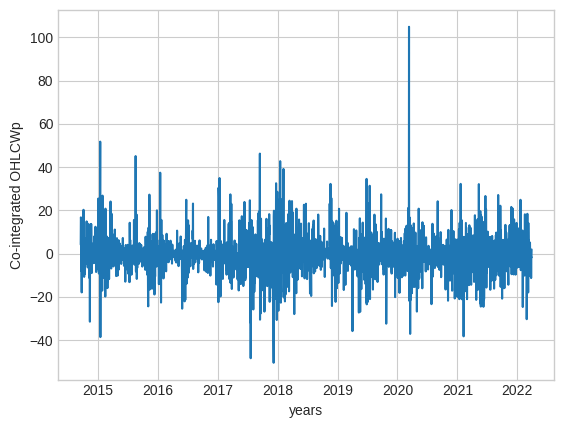

In [ ]:
plt.plot(daily_df_imputed.index, stationary_OHLCWp) # checks the plots of after the operation in the eigen vectors
plt.xlabel('years')
plt.ylabel('Co-integrated OHLCWp')

#<font color='red' size=7 >
IV- Granger Causation Model
</font>

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR

In [ ]:
def get_grangers_causation_results(df, maxlag, test='ssr_chi2test'):
    results = []

    for row in df.columns:
        row_result = []

        for col in df.columns:
            test_result = grangercausalitytests(df[[col, row]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            row_result.append(min_p_value)

        results.append(row_result)

    ind = [i + '_x' for i in df.columns]
    cols = [i + '_y' for i in df.columns]

    return pd.DataFrame(np.array(results), index=ind, columns=cols)

In [ ]:
# creating a time series split function
def ts_train_test_split(df, test_size):
    len_test = int(df.shape[0]*test_size)
    split_point = df.index[-len_test]

    train, test = df[df.index < split_point], df[df.index >= split_point]

    return train, test

In [ ]:
# splitting OHLCWp into train and test set
OHLCWp_train, OHLCWp_test = ts_train_test_split(np.log(daily_df_imputed), 0.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
model_ohlcwp = VAR(OHLCWp_train) # initializes VAR object
model_ohlcwp.select_order(maxlags=20).summary() # gets the summary

,AIC,BIC,FPE,HQIC
0,-22.39,-22.38,1.887e-10,-22.39
1,-37.75,-37.67,4.020e-17,-37.72
2,-37.85,-37.70*,3.653e-17,-37.79
3,-37.92,-37.70,3.412e-17,-37.84
4,-37.95,-37.66,3.304e-17,-37.84
5,-37.97,-37.61,3.233e-17,-37.84
6,-38.02,-37.60,3.073e-17,-37.87
7,-38.06*,-37.56,2.961e-17*,-37.88*
8,-38.05,-37.49,2.988e-17,-37.84
9,-38.04,-37.41,3.013e-17,-37.81


In [ ]:
get_grangers_causation_results(logdfc, 11)

In [ ]:
# creating a walk forward fuction that will split a time series into training and testing, and return a tuple of
# the test set and the predicited test set
def walk_forward_VAR(df, test_size, lag_order):

    train, test = ts_train_test_split(df, test_size) # splits the data into train and test set

    history = [list(x) for x in np.array(train)] # makes a list of lists from the train set
    forecasts = [] # empty list to store our forecasts

    for t in range(test.shape[0]): # for each test set,
        model = VAR(np.array(history)) # initialize a VAR model on the train set,
        model_fit = model.fit(lag_order) # fit the model
        yhat = model_fit.forecast(model.y, steps=1) # forecast just the next time step
        forecasts.append(list(yhat[0])) # add the forecast to the forecasts list
        history.append(list(np.array(test)[t])) # add the actual test value as the last observation of the
                                                # train set

    # return a tuple of the test set and the predicited test set as a tuple of dataframes
    return test, pd.DataFrame(np.array(forecasts), index=test.index)

In [ ]:
# OHLC walk forward
OHLCWp_VAR_results_test, OHLCWp_VAR_results_pred = walk_forward_VAR(logdfc, 0.25, 11)
OHLCWp_VAR_results = np.exp(OHLCWp_VAR_results_test), np.exp(OHLCWp_VAR_results_pred)

In [ ]:
# importing mean squared error metric
from sklearn.metrics import mean_squared_error as mse

In [ ]:
# defining mean absolute percentage error metric
def mape(df_true, df_pred, epsilon=1e-4):
    df_true[df_true == 0] = epsilon # replaces every occurence of zero in the true values with epsilon

    error = df_true - df_pred

    return 100 * np.mean(np.abs(error/df_true), axis=0)

In [ ]:
# defining a function to return both rmse and mape scores
def get_rmse_and_mape(df_true, df_pred):
    results = {'RMSE': mse(np.array(df_true), np.array(df_pred), multioutput='raw_values', squared=False),
               'MAPE (%)': mape(np.array(df_true), np.array(df_pred))}

    return pd.DataFrame(results, index=df_true.columns)

In [ ]:
get_rmse_and_mape(OHLCWp_VAR_results[0], OHLCWp_VAR_results[1]) # gets the rmse and mape scores of OHLC

,RMSE,MAPE (%)
Open,3.535842e+02,0.148350
High,9.994421e+02,1.731185
Low,1.178190e+03,2.101808
Close,1.531852e+03,2.718525
Volume,8.982777e+09,17.139771


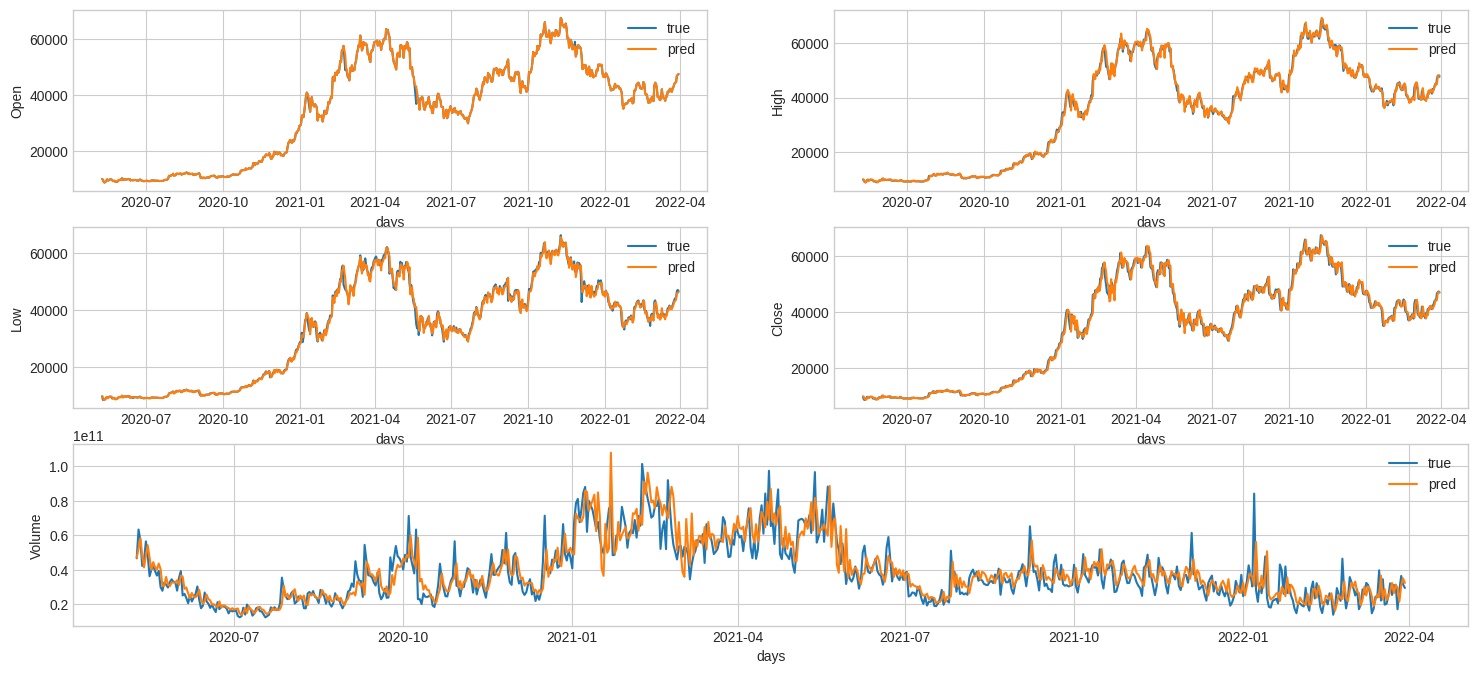

In [ ]:
# plots of our predictions and the true values for OHLCWp with VAR model
fig = plt.figure(figsize=(18, 8))
for i, col_test, col_pred in zip(range(1, 6), OHLCWp_VAR_results[0], OHLCWp_VAR_results[1]):
    if i == 5:
        a = fig.add_subplot(3, 1, 3)
        plt.plot(OHLCWp_VAR_results[0][col_test])
        plt.plot(OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.legend(['true', 'pred'])
        plt.xlabel('days')
        plt.ylabel(col_test)

    else:
        a = fig.add_subplot(3, 2, i)
        plt.plot(OHLCWp_VAR_results[0][col_test])
        plt.plot(OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.legend(['true', 'pred'])
        plt.xlabel('days')
        plt.ylabel(col_test)

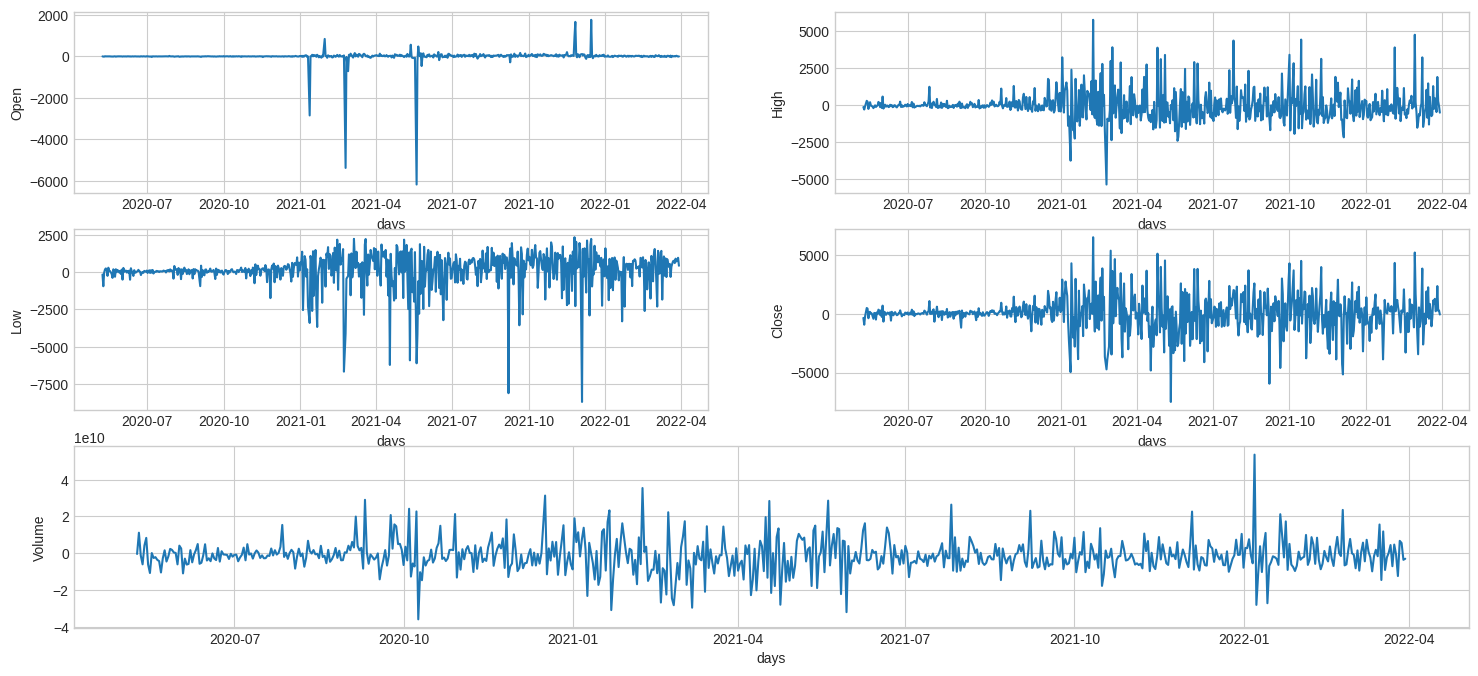

In [ ]:
# plots of our predictions and the true values for OHLCWp with VAR model
fig = plt.figure(figsize=(18, 8))
for i, col_test, col_pred in zip(range(1, 6), OHLCWp_VAR_results[0], OHLCWp_VAR_results[1]):
    if i == 5:
        a = fig.add_subplot(3, 1, 3)
        plt.plot(OHLCWp_VAR_results[0][col_test] - OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.xlabel('days')
        plt.ylabel(col_test)

    else:
        a = fig.add_subplot(3, 2, i)
        plt.plot(OHLCWp_VAR_results[0][col_test] - OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.xlabel('days')
        plt.ylabel(col_test)

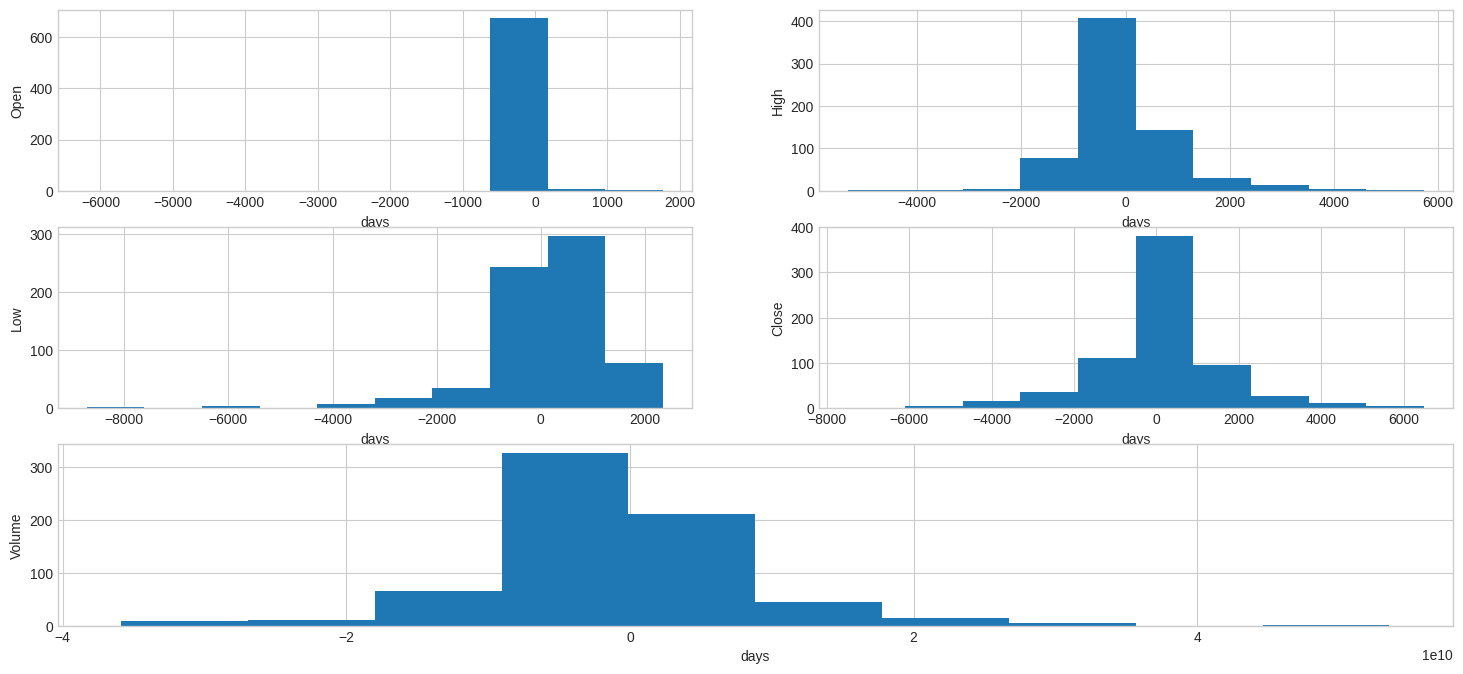

In [ ]:
# plots of our predictions and the true values for OHLCWp with VAR model
fig = plt.figure(figsize=(18, 8))
for i, col_test, col_pred in zip(range(1, 6), OHLCWp_VAR_results[0], OHLCWp_VAR_results[1]):
    if i == 5:
        a = fig.add_subplot(3, 1, 3)
        plt.hist(OHLCWp_VAR_results[0][col_test] - OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.xlabel('days')
        plt.ylabel(col_test)

    else:
        a = fig.add_subplot(3, 2, i)
        plt.hist(OHLCWp_VAR_results[0][col_test] - OHLCWp_VAR_results[1].iloc[:, col_pred])
        plt.xlabel('days')
        plt.ylabel(col_test)